In [31]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix


In [32]:
zip_path = "/content/archive.zip"
extract_path = "/content/fer2013"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset unzipped at:", extract_path)

train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")


Dataset unzipped at: /content/fer2013


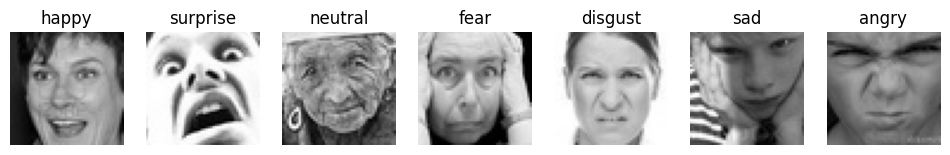

In [33]:
categories = os.listdir(train_dir)
plt.figure(figsize=(12,4))
for i, cat in enumerate(categories):
    img_name = os.listdir(os.path.join(train_dir, cat))[0]
    img_path = os.path.join(train_dir, cat, img_name)
    img = load_img(img_path, target_size=(48,48))
    plt.subplot(1, len(categories), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cat)
    plt.axis('off')
plt.show()


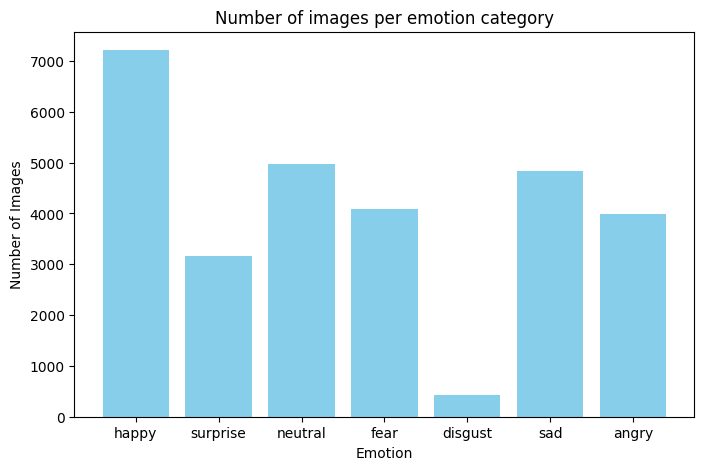

In [35]:
counts = [len(os.listdir(os.path.join(train_dir, c))) for c in categories]
plt.figure(figsize=(8,5))
plt.bar(categories, counts, color='skyblue')
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.title("Number of images per emotion category")
plt.show()


In [36]:
IMG_SIZE = (48,48)

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',  # MobileNetV2 expects 3 channels
    batch_size=32,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [38]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48,48,3))
base_model.trainable = False  # freeze base


inputs = Input(shape=(48,48,3))

features = base_model(inputs, training=False)

pooled_features = GlobalAveragePooling2D()(features)

dense_layer = Dense(128, activation='relu')(pooled_features)
dropout_layer = Dropout(0.5)(dense_layer)

outputs = Dense(len(categories), activation='softmax')(dropout_layer)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipython-input-1590737920.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48,48,3))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
TransferLearningModel = model.fit(
    train_data,
    validation_data=test_data,
    epochs=3
)


Epoch 1/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 53s 59ms/step - accuracy: 0.2788 - loss: 1.7696 - val_accuracy: 0.3288 - val_loss: 1.6609
Epoch 2/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3028 - loss: 1.7217 - val_accuracy: 0.3264 - val_loss: 1.6553
Epoch 3/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.3156 - loss: 1.7009 - val_accuracy: 0.3381 - val_loss: 1.6463


In [41]:
train_acc = TransferLearningModel.history['accuracy'][-1]
val_acc = TransferLearningModel.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")


Final Training Accuracy: 31.56%
Final Validation Accuracy: 33.81%


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step


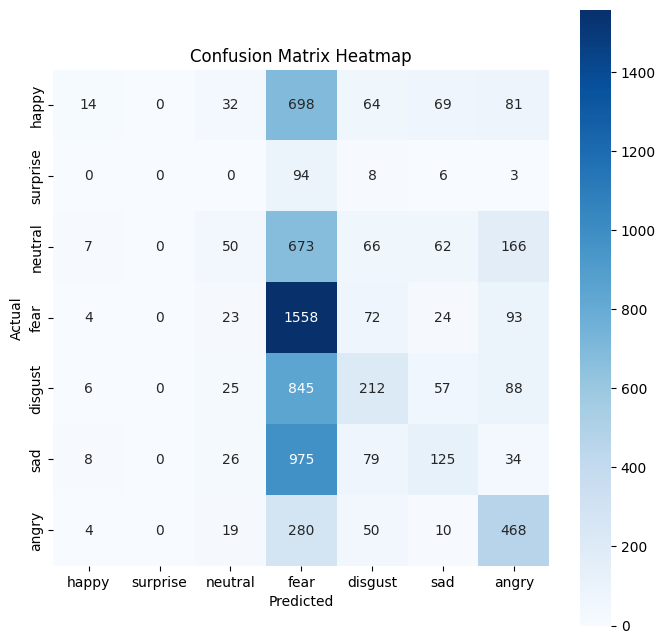

In [45]:
y_true = test_data.classes

# Predicted labels
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [43]:
model.save("fer_mobilenetv2_model.h5")
print("Model saved as fer_mobilenetv2_model.h5")


Model saved as fer_mobilenetv2_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


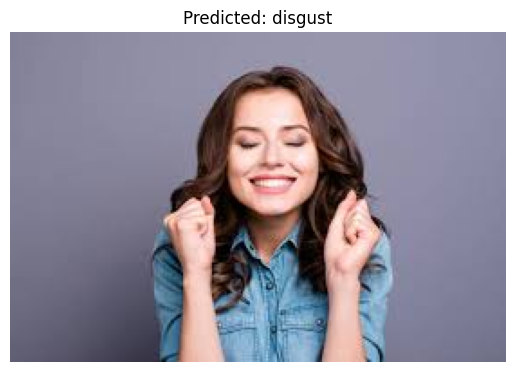

Predicted Emotion: disgust


In [44]:
def predict_external_image(img_path):
    # Display original image
    img_display = load_img(img_path, color_mode='rgb')

    # Resize for model
    img_model = load_img(img_path, target_size=(48,48), color_mode='rgb')
    img_array = img_to_array(img_model)/255.0
    img_input = np.expand_dims(img_array, axis=0)

    # Predict
    pred_idx = np.argmax(model.predict(img_input)[0])
    emotion = categories[pred_idx]

    # Show image
    plt.imshow(np.array(img_display))
    plt.title(f"Predicted: {emotion}")
    plt.axis('off')
    plt.show()

    print("Predicted Emotion:", emotion)

# Example:
predict_external_image("/content/download.jpg")
